In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from scipy import stats
import duckdb

In [2]:
df = pd.read_csv('file_out2.csv')
df.head()

,Unnamed: 0,InvoiceID,Date,ProductID,TotalSales,Discount,CustomerID,Quantity
0,0,328,2019-12-27,1684,796.610169,143.389831,185,4
1,1,329,2019-12-27,524,355.932203,64.067797,185,2
2,2,330,2019-12-27,192,901.694915,162.305085,230,4
3,3,330,2019-12-27,218,182.754237,32.895763,230,1
4,4,330,2019-12-27,247,780.101695,140.418305,230,4


In [3]:
del df['Unnamed: 0']
df.head()

,InvoiceID,Date,ProductID,TotalSales,Discount,CustomerID,Quantity
0,328,2019-12-27,1684,796.610169,143.389831,185,4
1,329,2019-12-27,524,355.932203,64.067797,185,2
2,330,2019-12-27,192,901.694915,162.305085,230,4
3,330,2019-12-27,218,182.754237,32.895763,230,1
4,330,2019-12-27,247,780.101695,140.418305,230,4


In [4]:
df.shape

(29103, 7)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29103 entries, 0 to 29102
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   InvoiceID   29103 non-null  int64  
 1   Date        29103 non-null  object 
 2   ProductID   29103 non-null  int64  
 3   TotalSales  29103 non-null  float64
 4   Discount    29103 non-null  float64
 5   CustomerID  29103 non-null  int64  
 6   Quantity    29103 non-null  int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 1.6+ MB


In [6]:
df.nunique()

InvoiceID     14079
Date           1268
ProductID      1940
TotalSales     7013
Discount       6797
CustomerID      507
Quantity         59
dtype: int64

In [7]:
df[df.duplicated(keep=False) == True]

,InvoiceID,Date,ProductID,TotalSales,Discount,CustomerID,Quantity
110,385,2019-12-31,192,950.000000,171.000000,230,4
111,385,2019-12-31,192,950.000000,171.000000,230,4
302,524,2019-07-09,527,715.864407,128.855593,230,4
303,524,2019-07-09,527,715.864407,128.855593,230,4
483,650,2019-07-16,559,206.101695,37.098305,230,1
...,...,...,...,...,...,...,...
16768,6570,2020-12-22,1919,474.576271,85.423729,230,2
16771,6572,2020-12-23,189,546.440678,98.359322,230,2
16772,6572,2020-12-23,189,546.440678,98.359322,230,2
16775,6572,2020-12-23,251,542.372881,97.627119,230,2


In [8]:
df.drop_duplicates(keep='first', inplace= True)

In [9]:
df[df['TotalSales'] == 0]

,InvoiceID,Date,ProductID,TotalSales,Discount,CustomerID,Quantity
2328,1930,2019-10-05,885,0.0,0.0,17,0
6533,4718,2019-04-13,751,0.0,0.0,404,0
8663,242,2019-01-15,1790,0.0,0.0,122,4
8665,244,2019-02-15,1470,0.0,0.0,129,4
8667,246,2019-02-28,1499,0.0,0.0,129,4
...,...,...,...,...,...,...,...
28893,196,2023-02-15,900,0.0,0.0,230,0
28894,197,2023-02-16,795,0.0,0.0,230,0
28895,198,2023-02-18,628,0.0,0.0,230,0
28896,198,2023-02-18,900,0.0,0.0,230,0


In [10]:
df = df[(df['TotalSales'] != 0) & (df['Quantity'] != 0)]

In [11]:
del df['ProductID']
del df['Quantity']
del df['Discount']
df.head()

,InvoiceID,Date,TotalSales,CustomerID
0,328,2019-12-27,796.610169,185
1,329,2019-12-27,355.932203,185
2,330,2019-12-27,901.694915,230
3,330,2019-12-27,182.754237,230
4,330,2019-12-27,780.101695,230


In [12]:
df.shape

(28634, 4)

In [13]:
df['Date'] = pd.to_datetime(df['Date'])

In [14]:
df['Date'].min(), df['Date'].max() # 50개월정도

(Timestamp('2019-01-02 00:00:00'), Timestamp('2023-03-25 00:00:00'))

In [15]:
def dfsql(query):
    return duckdb.query(query).df()

In [16]:
cust_df = dfsql('''
                select df.CustomerID, DATE '2023-03-26' - min(df.Date) as SignupDays, DATE '2023-03-26' - max(df.Date) as RecentOrder,
                count(DISTINCT df.InvoiceID) as Frequency, avg(tmp.summ) as Monetary 
                from df JOIN (select CustomerID, InvoiceID, sum(TotalSales) as summ from df group by CustomerID, InvoiceID) as tmp
                ON tmp.CustomerID = df.CustomerID group by df.CustomerID
                ''')

In [17]:
cust_df

,CustomerID,SignupDays,RecentOrder,Frequency,Monetary
0,230,1544 days,1 days,784,5444.248275
1,267,1539 days,1181 days,36,971.872175
2,129,1542 days,514 days,50,1659.880587
3,344,1461 days,32 days,93,2383.916530
4,117,1539 days,73 days,146,1759.190852
...,...,...,...,...,...
502,273,220 days,16 days,2,5307.118644
503,65,31 days,31 days,1,7118.644068
504,498,60 days,60 days,1,3220.338983
505,264,33 days,33 days,1,3683.050847


In [18]:
cust_df['SignupDays'] = cust_df['SignupDays'].dt.days
cust_df['RecentOrder'] = cust_df['RecentOrder'].dt.days
cust_df.head()

,CustomerID,SignupDays,RecentOrder,Frequency,Monetary
0,230,1544,1,784,5444.248275
1,267,1539,1181,36,971.872175
2,129,1542,514,50,1659.880587
3,344,1461,32,93,2383.916530
4,117,1539,73,146,1759.190852


array([[<Axes: title={'center': 'SignupDays'}>,
        <Axes: title={'center': 'RecentOrder'}>],
       [<Axes: title={'center': 'Frequency'}>,
        <Axes: title={'center': 'Monetary'}>]], dtype=object)

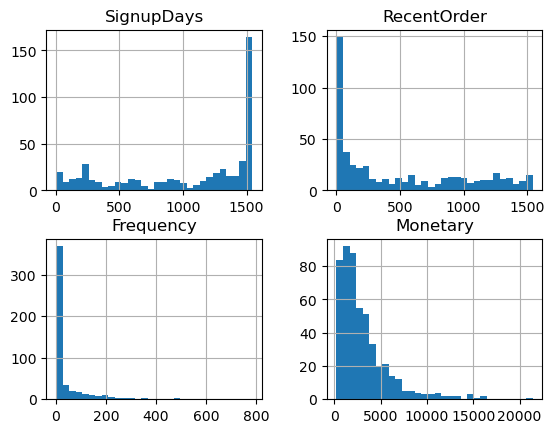

In [19]:
cust_df[cust_df.columns[1:]].hist(bins=30)

### 총 고객 수 507, 대부분 고객이 한달에 1번 미만 구매하고, 한번 구매할 때 최소 200, 평균적으로 3000달러 쯤 쓴다.

# 회사 : 컴퓨터 부품 제조회사, 고객 : 컴퓨터 부품 매장

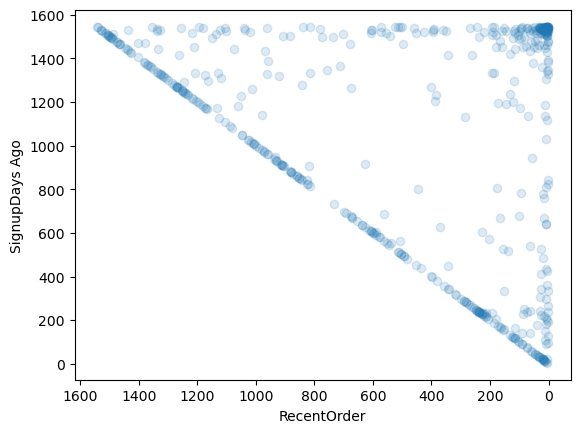

In [20]:
plt.scatter(cust_df['RecentOrder'], cust_df['SignupDays'], alpha=0.15)
plt.ylabel('SignupDays Ago')
plt.xlabel('RecentOrder')
plt.gca().invert_xaxis()
plt.show()
# 한 점의 y축 - 가입지속 일 수, x축 - 최근 거래일    ( 같은 y에서 오른쪽에 있을 수록 R_score가 높은 점 )
# SignupDays 가 낮은 고객은 신규고객 -> segment 1  회사 포스터, 회사 로고가 그려진 베개 등의 사은품을 동봉하여 보내서 
                                                                    # 회사 내에 비치하도록 유도한다.
# 맨 오른쪽 위의 점들은 4년넘게 구매를 해주는 고객들이다   -> segment 2  충성도가 높은 고객, 매장에서도 컴퓨터가 필요할테니 컴퓨터 완제품같은
                                                        # 고비용의 기념선물을 보내주면 좋을 것 같다.

# 대각선 위의 점들   -> segment 3   첫 구매 이후 거래가 없는 고객, 첫 구매에서 많이 구매한 제품들의 문제점을 파악하거나
                        #  전화설문 등을 해서 특별할인코드, 마일리지 등을 설문 다음달에 제공하여 재 사용을 유도한다.
                        #  설문 결과를 토대로 문제를 개선하고 개선점 체험을 유도하여 다시 고객이 되게 한다.

In [21]:
cust_df['Seg1'] = 0
cust_df.loc[cust_df['SignupDays'] <= 60, 'Seg1'] = 1

In [22]:
(cust_df['Frequency'] / cust_df['SignupDays'] * 30).mean()  # 평균적으로 한달에 1.13번 구매
                                                            # RecentOrder <= 60 & SignupDays >= 4년인 고객 -> segment 2

1.1340477752806735

In [23]:
pd.to_datetime('2023-03-26') - pd.to_datetime('2019-03-26') 

Timedelta('1461 days 00:00:00')

In [24]:
cust_df['Seg2'] = 0
cust_df.loc[(cust_df['SignupDays'] >= 1461) & (cust_df['RecentOrder'] <= 60), 'Seg2'] = 1


In [25]:
cust_df['Seg2'].value_counts()

Seg2
0    424
1     83
Name: count, dtype: int64

In [26]:
cust_df['Seg3'] = 0
cust_df.loc[(cust_df['SignupDays'] == cust_df['RecentOrder']) & (cust_df['SignupDays'] > 60), 'Seg3'] = 1

In [50]:
cust_df['Seg3'].value_counts() # 187 / 507 이 한번 이용하고 그만 두었거나 집계 이전부터 이용해오다가 이용을 그만 둠 

Seg3
0    320
1    187
Name: count, dtype: int64

In [28]:
cust_df['RecentOrder'].describe() 

count     507.000000
mean      493.528600
std       507.835425
min         1.000000
25%        30.000000
50%       244.000000
75%       936.500000
max      1542.000000
Name: RecentOrder, dtype: float64

<Axes: >

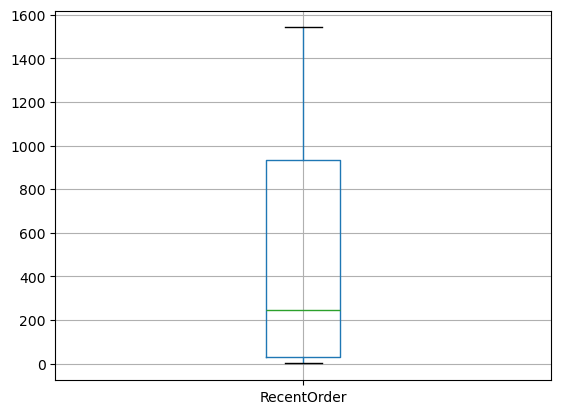

In [29]:
cust_df.boxplot(column=['RecentOrder']) # 60, 244, 936 

In [30]:
cust_df['R_Score'] = 2
cust_df.loc[(cust_df['RecentOrder'] <=  60), 'R_Score'] = 3
cust_df.loc[((cust_df['RecentOrder'] > 244) & (cust_df['RecentOrder'] < 936)), 'R_Score'] = 1
cust_df.loc[(cust_df['RecentOrder'] >=  936), 'R_Score'] = 0

<Axes: xlabel='R_Score'>

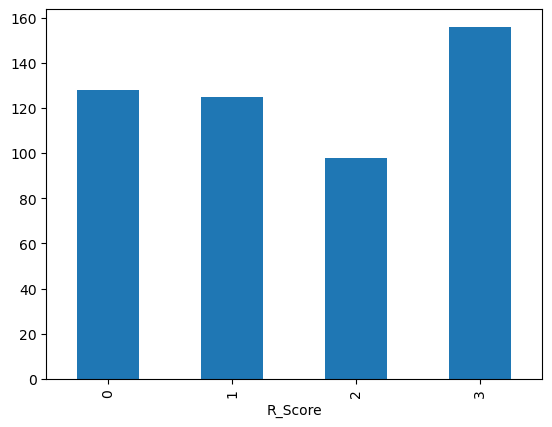

In [31]:
cust_df['R_Score'].value_counts().sort_index().plot(kind="bar")

<Axes: >

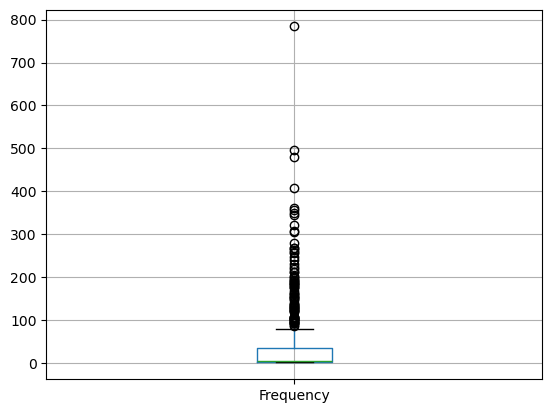

In [32]:
cust_df.boxplot(column=['Frequency']) # 4년동안 집계된 고객이랑, 2년동안 집계된 고객이랑 차이날수밖에 없다.

In [33]:
cust_df['Freq/Signup'] = cust_df['Frequency']/cust_df['SignupDays'] * 30 # 30일 평균 freq
cust_df.head()

,CustomerID,SignupDays,RecentOrder,Frequency,Monetary,Seg1,Seg2,Seg3,R_Score,Freq/Signup
0,230,1544,1,784,5444.248275,0,1,0,3,15.233161
1,267,1539,1181,36,971.872175,0,0,0,0,0.701754
2,129,1542,514,50,1659.880587,0,0,0,1,0.972763
3,344,1461,32,93,2383.916530,0,1,0,3,1.909651
4,117,1539,73,146,1759.190852,0,0,0,2,2.846004


<Axes: >

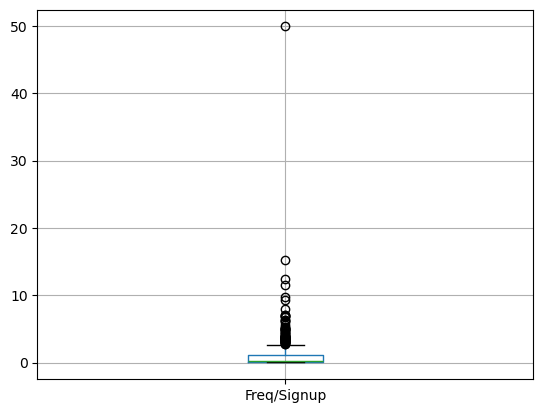

In [34]:
cust_df[cust_df['Seg1'] != 1].boxplot(column=['Freq/Signup'])

In [35]:
cust_df['Freq/Signup'].describe() #평균이랑 3 사분위수가 거의 비슷하다 

count    507.000000
mean       1.134048
std        2.836724
min        0.019455
25%        0.046841
50%        0.256410
75%        1.217617
max       49.921875
Name: Freq/Signup, dtype: float64

In [36]:
cust_df[cust_df['Freq/Signup'] > 30] 

,CustomerID,SignupDays,RecentOrder,Frequency,Monetary,Seg1,Seg2,Seg3,R_Score,Freq/Signup
305,233,128,1,213,5825.345761,0,0,0,3,49.921875


In [37]:
df[df['CustomerID'] == 233] # 특이값때문에 Frequency가 들어가는 곳에서는 절사평균을 사용해야겠다고 생각이됨 

,InvoiceID,Date,TotalSales,CustomerID
24784,13396,2022-12-12,3703.389830,233
24823,13250,2022-11-25,1142.737288,233
24824,13251,2022-11-25,1142.737288,233
24825,13252,2022-11-25,1142.737288,233
24826,13316,2022-12-02,4805.423729,233
...,...,...,...,...
29034,13628,2023-01-14,8723.322034,233
29035,13629,2023-01-14,709.754237,233
29079,13606,2023-01-10,5945.016949,233
29086,13613,2023-01-12,1237.711864,233


In [38]:
stats.trim_mean((cust_df['Frequency'] / cust_df['SignupDays'] * 30), 0.1)   # 그냥 평균은 1.13 1 
                                                                            # 절사평균으로 구하면 평균적으로 한달에 0.62번정도
                                                                            # 0.05, 0.25, 0.5, 1

0.619746569947197

In [39]:
cust_df['F_Score'] = 3
cust_df.loc[(cust_df['Freq/Signup'] >=  1), 'F_Score'] = 5
cust_df.loc[((cust_df['Freq/Signup'] < 1) & (cust_df['Freq/Signup'] >= 0.5)), 'F_Score'] = 4
cust_df.loc[((cust_df['Freq/Signup'] > 0.05) & (cust_df['Freq/Signup'] <= 0.25)), 'F_Score'] = 2
cust_df.loc[(cust_df['Freq/Signup'] <=  0.05), 'F_Score'] = 1

<Axes: xlabel='F_Score'>

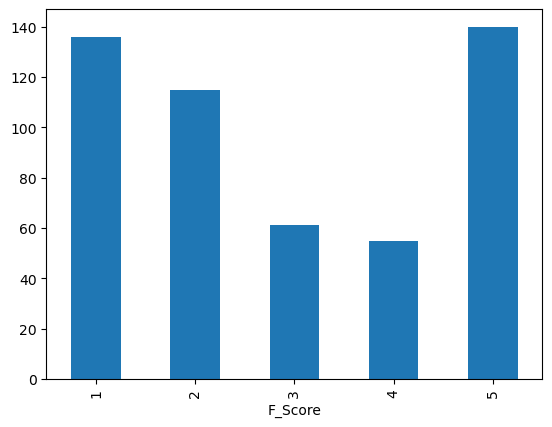

In [40]:
cust_df['F_Score'].value_counts().sort_index().plot(kind="bar")

In [41]:
cust_df['Monetary'].describe()

count      507.000000
mean      3133.066154
std       2885.956897
min        233.050847
25%       1193.633406
50%       2203.389831
75%       4040.091451
max      21398.305085
Name: Monetary, dtype: float64

<Axes: >

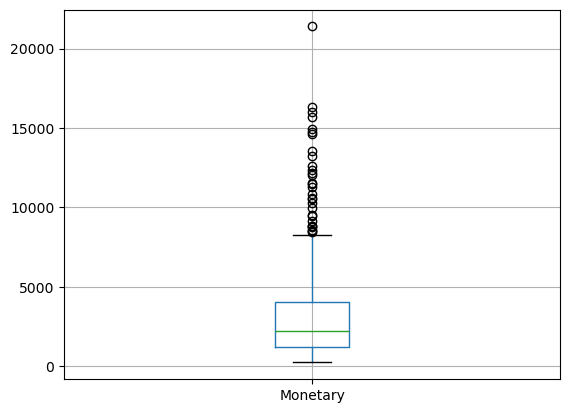

In [42]:
cust_df.boxplot(column=['Monetary']) # 1200, 2200, 4000, 8000

In [43]:
cust_df['M_Score'] = 3
cust_df.loc[(cust_df['Monetary'] >=  8000), 'M_Score'] = 5
cust_df.loc[((cust_df['Monetary'] < 8000) & (cust_df['Monetary'] >= 4000)), 'M_Score'] = 4
cust_df.loc[((cust_df['Monetary'] > 1200) & (cust_df['Monetary'] <= 2200)), 'M_Score'] = 2
cust_df.loc[(cust_df['Monetary'] <=  1200), 'M_Score'] = 1

<Axes: xlabel='M_Score'>

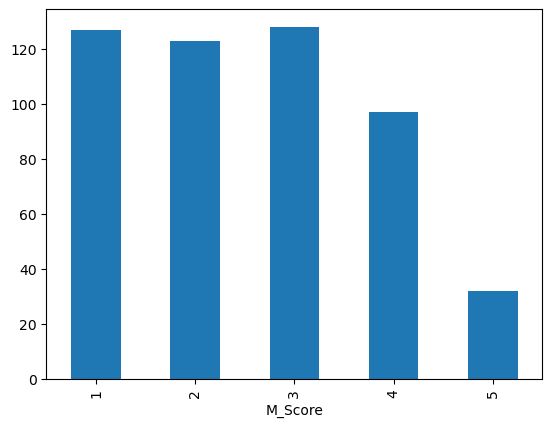

In [44]:
cust_df['M_Score'].value_counts().sort_index().plot(kind="bar")

In [45]:
cust_df.head()

,CustomerID,SignupDays,RecentOrder,Frequency,Monetary,Seg1,Seg2,Seg3,R_Score,Freq/Signup,F_Score,M_Score
0,230,1544,1,784,5444.248275,0,1,0,3,15.233161,5,4
1,267,1539,1181,36,971.872175,0,0,0,0,0.701754,4,1
2,129,1542,514,50,1659.880587,0,0,0,1,0.972763,4,2
3,344,1461,32,93,2383.916530,0,1,0,3,1.909651,5,3
4,117,1539,73,146,1759.190852,0,0,0,2,2.846004,5,2


In [46]:
RFM_df = cust_df[['CustomerID', 'Seg1', 'Seg2', 'Seg3', 'R_Score', 'F_Score', 'M_Score']]
# RFM_df.shape -> (507, 7)
RFM_df.head(10)
# Seg1 = 신규고객  NewComer  
# Seg3 = 휴면고객                                                     Inactive
# Seg4 = 돈을 많이쓰지만(F,M이 높은) 최근 주문이 없는(R이 낮은) 고객  Prime
# Seg5 = 돈을 많이쓰고 최근에도 주문을 한 고객(최고의 고객)           HighValue
# 나머지 = 일반적인 마케팅                                            Others

# Seg2 = 충성적인 고객 (고객감사선물 보내주기)                        ExtraGift 

,CustomerID,Seg1,Seg2,Seg3,R_Score,F_Score,M_Score
0,230,0,1,0,3,5,4
1,267,0,0,0,0,4,1
2,129,0,0,0,1,4,2
3,344,0,1,0,3,5,3
4,117,0,0,0,2,5,2
5,181,0,1,0,3,5,3
6,454,0,1,0,3,5,3
7,191,0,1,0,3,5,4
8,270,0,1,0,3,5,3
9,452,0,1,0,3,2,2


In [47]:
RFM_df['Segment'] = 'Others'
RFM_df.loc[(RFM_df['R_Score'] >= 2) & ((RFM_df['F_Score'] + RFM_df['M_Score']) >= 7), 'Segment'] = 'Prime'
RFM_df.loc[(RFM_df['R_Score'] < 2) & ((RFM_df['F_Score'] + RFM_df['M_Score']) >= 7), 'Segment'] = 'HighValue'
RFM_df.loc[RFM_df['Seg1'] == 1, 'Segment'] = 'NewComer'
RFM_df.loc[RFM_df['Seg3'] == 1, 'Segment'] = 'Inactive'
RFM_df.loc[RFM_df['Seg2'] == 1, 'Segment'] += ' + ExtraGift'

/var/folders/bs/pd1ffxhj4pj0vljl0w05mq1m0000gn/T/ipykernel_1580/1351396662.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RFM_df['Segment'] = 'Others'


In [48]:
tmp = RFM_df['Segment'].value_counts().sort_index()

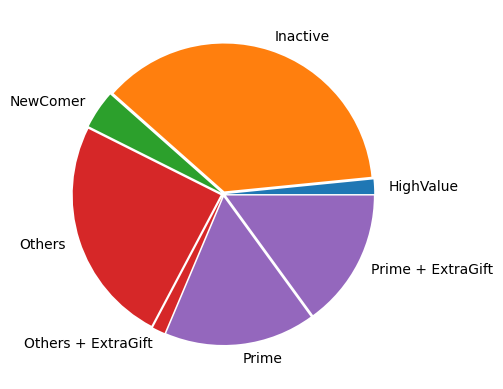

In [49]:
cmap = {}

for idx in tmp.index:
    first_letter = idx[0]
    if first_letter not in cmap:
        cmap[first_letter] = plt.cm.tab10.colors[len(cmap) % len(plt.cm.tab10.colors)]

colors = [cmap[idx[0]] for idx in tmp.index]
explode = [0.02 for i in range(len(tmp))]
plt.pie(tmp.values, labels=tmp.index, explode=explode, colors=colors)
plt.show()

### HighValue와 Prime은 대형 컴퓨터부품 도매업자 

### NewComer : 신규고객
    잠재적으로 돈을 많이 쓰는 고객을 유치하도록 회사 포스터, 회사 로고가 그려진 베개 등의 사은품을 동봉하여 보내서 매장에 비치하도록 유도하고,
    회사에 친밀감을 가지도록한다.

### Inactive : 첫 구매 이후 거래가 없는 고객, 잠재적으로 돈을 많이 쓰는 고객이 있을 수 있다.
    첫 구매에서 많이 구매한 제품들의 문제점을 파악하거나 전화설문 등을 해서 특별할인코드, 마일리지 등을 설문 다음달에 제공하여 재사용을 유도
    설문 결과를 토대로 문제를 개선하고 개선점 체험을 유도하여 다시 고객이 되게 한다. ( + 신규고객 혜택까지 제공 )

### HighValue : F, M이 높고 R이 낮은 고객(이탈한 우수고객)
    고객이 가장 많이 이탈하게 된 경쟁사의 혜택을 파악하고 그보다 더 좋은 혜택 제안과 함께 공식적으로 제휴를 맺는다.

### Prime : R, F, M 모두 높은 고객
    공식적으로 제휴를 맺고, 신제품이 나오면 물량을 가장 우선적으로 제공, 공식사이트에 회사 공식판매처로 등재하는 등의 혜택을 제공해준다.

### Others : F, M이 그저 그런 나머지고객 
    따로 혜택을 제공해주지 않는다. 

### ExtraGift : 오랜 기간동안 찾아준 충성도가 높은 고객
    매장에서도 컴퓨터가 필요할테니 컴퓨터 완제품같은 고비용의 기념선물을 보내준다면 큰 유대감이 생겨서 절대 이탈고객이 되지 않을것이다.